In [53]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

# load images in shape (m, 28,28,1), num_channels is taken 1
X_train = mnist.train.images.reshape((55000,28,28,1))
X_test = mnist.test.images.reshape((10000, 28, 28, 1))
X_valid = mnist.validation.images.reshape((5000,28,28,1))


# load labels with shape (m, 10)
y_train = mnist.train.labels
y_test = mnist.test.labels
y_valid = mnist.validation.labels





Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:


# Architecture: conv_1 = 32 >> conv2 = 64 >> padding = "SAME" >> flatten >> 1 dense_layer >> cost

def initialize():
    
    # initialize weights with xavier initializer to make variance "2/n"
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

    W1 = tf.get_variable(name="W1", initializer=tf.contrib.layers.xavier_initializer(),
                         shape=[28,28,1,16],regularizer=regularizer)
    
    W2 = tf.get_variable(name="W2", shape=[28,28,16,32],
                         initializer=tf.contrib.layers.xavier_initializer(),regularizer=regularizer)
    return W1, W2


In [0]:


def forward_prop(X, W1, W2):
    

    # create two convolution layers
    # X >> convolve >> Z1 >> activation >> max_pool >> convolve >> Z2 >> activation >> max_pool>> flatten

    #  convolution layer 1
    Z1 = tf.nn.conv2d(X, filter=W1, padding="SAME", strides=[1, 1, 1, 1])
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, [1, 2, 2, 1], strides=[1, 1, 1, 1], padding="SAME")

    # convolution layer 2
    Z2 = tf.nn.conv2d(P1, filter=W2, strides=[1, 1, 1, 1], padding="SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, [1, 2, 2, 1], padding='SAME', strides=[1, 1, 1, 1])
    
    # flatten layer
    F = tf.contrib.layers.flatten(P2)
    
    # fully connected layer
    L = tf.contrib.layers.fully_connected(F, num_outputs = 10, activation_fn=None)
    #tf.nn.dropout(L,keep_prob=0.5)
    
    return L



In [0]:

def find_cost(L, Y):
   
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=L))
    return cost



In [0]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:

def model(X_train, Y_train,X_test,Y_test, learn_rate=0.009, minibatch=64, epochs=100):
    tf.reset_default_graph()
    # make tensorflow graph
    # I am not using minibatch and validation data

    # create placeholders to hold Batch of images and their labels
    X = tf.placeholder(tf.float32, name="X", shape=(None, 28,28,1))
    Y = tf.placeholder(tf.float32, name="Y", shape= (None, 10))

    # later we'll plot graph
    costs = []

    W1, W2 = initialize()
    Z3 = forward_prop(X, W1, W2)
    cost = find_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(loss=cost)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Z3, axis=1), tf.argmax(Y, axis=1)),"float"))

    with tf.Session() as sess:
      
        sess.run(tf.global_variables_initializer())
        
        
        for epoch in range(epochs):
            minibatch_cost = 0
            num_minibatch = int(X_train.shape[0]/minibatch)
            minibatches = random_mini_batches(X_train, Y_train,128)
            
            for batch in minibatches:
              (X_mini,Y_mini) = batch
              _, total_cost = sess.run([optimizer, cost], feed_dict={X: X_mini, Y: Y_mini})
              minibatch_cost += total_cost
              
            costs.append(minibatch_cost)
            print(epoch+1, " epochs cost ", minibatch_cost)
            print("Train accuracy : ", sess.run(accuracy, feed_dict={X: X_train[:5000], Y: Y_train[:5000]}))
            print("Test accuracy : ", sess.run(accuracy, feed_dict={X: X_test[:5000], Y: Y_test[:5000]}))

        plt.plot(np.squeeze(costs))
        plt.ylabel("Cost")
        plt.xlabel("epochs")

        # check train accuracy
        
        
        



1  epochs cost  413.45312608778477
Train accuracy :  0.9278
Test accuracy :  0.9144
2  epochs cost  117.00037544593215
Train accuracy :  0.9316
Test accuracy :  0.9172
3  epochs cost  106.09515355527401
Train accuracy :  0.9392
Test accuracy :  0.9226
4  epochs cost  104.41658892482519
Train accuracy :  0.9492
Test accuracy :  0.9244
5  epochs cost  98.55731804668903
Train accuracy :  0.9416
Test accuracy :  0.9184
6  epochs cost  99.02692558988929
Train accuracy :  0.9482
Test accuracy :  0.9212
7  epochs cost  100.29497876763344
Train accuracy :  0.954
Test accuracy :  0.916
8  epochs cost  101.73382568731904
Train accuracy :  0.9336
Test accuracy :  0.901
9  epochs cost  109.48132852837443
Train accuracy :  0.9468
Test accuracy :  0.922
10  epochs cost  97.46745849400759
Train accuracy :  0.9454
Test accuracy :  0.9156
11  epochs cost  100.95887476578355
Train accuracy :  0.9382
Test accuracy :  0.9184
12  epochs cost  119.53756131231785
Train accuracy :  0.933
Test accuracy :  0.89

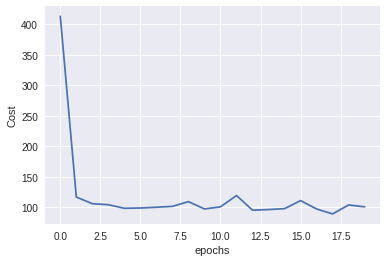

In [90]:
model(X_train,y_train,X_test,y_test, epochs=20)